# Clustering

In [2]:
import math
import torch
import operator
import matplotlib.pyplot as plt

In [3]:
torch.manual_seed(42)
torch.set_printoptions(precision=3, linewidth=120, sci_mode=False)
plt.style.use('fast')

In [4]:
n_clusters = 6
n_samples = 250

In [37]:
centroids = torch.rand(n_clusters, 2) * 70 - 35

In [38]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [39]:
def sample(m): return MultivariateNormal(m, torch.diag(tensor([5., 5.]))).sample((n_samples,))

In [40]:
slices = [sample(c) for c in centroids]
data = torch.cat(slices)
data.shape

torch.Size([1500, 2])

In [58]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _, ax = plt.subplots()
    for i, centroid in enumerate(centroids):
        samples = data[i*n_samples:(i+1)*n_samples]
        ax.scatter(samples[:, 0], samples[:, 1], s=1.5)
        ax.plot(*centroid, markersize=10, marker='x', color='k', mew=5)
        ax.plot(*centroid, markersize=5, marker='o', color='m', mew=2)


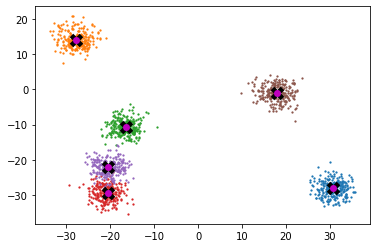

In [59]:
plot_data(centroids, data, n_samples)

# Meanshift

The algorithm is as follows:
* For each data point x in the sample X, find the distance between that point x and every other point in X
* Create weights for each point in X by using the **Gaussian kernel** of that point's distance to x
    * This weighting approach penalizes points further away from x
    * The rate at which the weights fall to zero is determined by the **bandwidth**, which is the standard deviation of the Gaussian
* Update x as the weighted average of all other points in X, weighted based on the previous step

This will iteratively push points that are close together even closer until they are next to each other.

In [55]:
midp = data.mean(dim=0)

In [56]:
midp

tensor([ -6.201, -12.871])

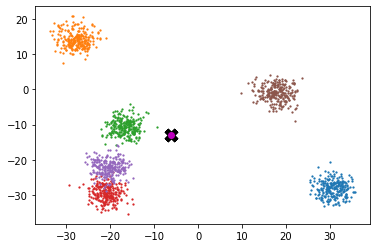

In [64]:
plot_data([midp]*n_clusters, data, n_samples)

In [65]:
def gaussian(d, bw): return torch.exp(-0.5*((d/bw)**2)) / (bw*math.sqrt(2*math.pi))

In [74]:
def plot_func(f):
    x = torch.linspace(-50, 50, 200)
    plt.plot(x, f(x))

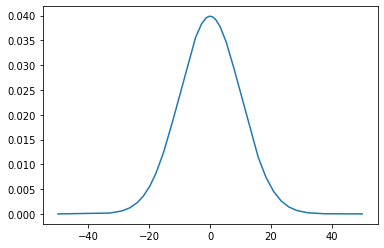

In [75]:
from functools import partial
plot_func(partial(gaussian, bw=10))

In [76]:
a = torch.rand(10)
b = torch.rand(10)
a.shape, b.shape

(torch.Size([10]), torch.Size([10]))

In [78]:
X = data.clone()
x = data[0]

In [79]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1500, 2]))

In [85]:
dist = ((x-X)**2).sum(dim=1).sqrt()

In [86]:
dist.shape

torch.Size([1500])

In [121]:
dist2 = torch.einsum('ij, ij-> i', x-X, x-X).sqrt()

In [122]:
dist2.shape

torch.Size([1500])

In [123]:
from fastcore.test import test_close

In [124]:
test_close(dist, dist2, eps=1e-3)

In [125]:
weight = gaussian(dist, 2.5)
weight

tensor([    0.160,     0.016,     0.006,  ...,     0.000,     0.000,     0.000])

In [126]:
weight.shape, X.shape

(torch.Size([1500]), torch.Size([1500, 2]))

In [127]:
weight[:, None] * X

tensor([[     4.573,     -5.286],
        [     0.506,     -0.457],
        [     0.182,     -0.174],
        ...,
        [     0.000,     -0.000],
        [     0.000,     -0.000],
        [     0.000,     -0.000]])

In [129]:
def one_update(X):
    for i, x in enumerate(X):
        dist = torch.einsum('ij,ij -> i', x-X, x-X).sqrt()
        weight = gaussian(dist, 2.5)
        X[i] = (weight[:, None]*X).sum(0)/weight.sum()

In [130]:
from tqdm.notebook import trange

In [131]:
def meanshift(data):
    X = data.clone()
    for it in trange(5): one_update(X)
    return X

In [132]:
X = meanshift(data)

  0%|          | 0/5 [00:00<?, ?it/s]

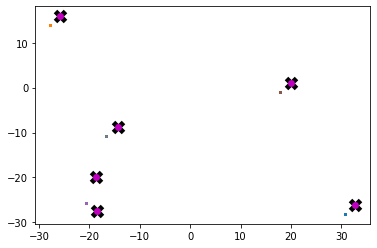

In [134]:
plot_data(centroids+2, X, n_samples)

# Animate it! 🔥

In [135]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [138]:
def do_one(d):
    if d: one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [139]:
X = data.clone()
fig, ax = plt.subplots()
anim = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=True)
plt.close()
HTML(anim.to_jshtml())

# Batched

In [140]:
bs = 5
X = data.clone()
x = X[:bs]
x.shape, X.shape

(torch.Size([5, 2]), torch.Size([1500, 2]))